In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from IPython.core.pylabtools import figsize

Load Dataset and Read Dataset

In [ ]:
df = pd.read_csv("Customer-Segmentation.csv")
print(df.shape)
print(df.head())
df.info()

Preprocess Data: handle null value

In [ ]:
#check whether there are null values
print(df.isnull().sum())

In [ ]:
#handle null values: since only the feature 'income' has 24 null values, we can drop it since 24 is not a big number
df = df.dropna()

In [ ]:
df.nunique()

In [ ]:
#drop columns that only have a single unique value
df = df.drop(['Z_CostContact', 'Z_Revenue', 'Dt_Customer'], axis=1)

Explorative Data Analysis (EDA)

In [ ]:
df.describe().T

In [ ]:
# create histogram for numerical features
def make_histogram(df, column):

  plt.figure(figsize(5, 3))
  sns.histplot(df[column], kde=True)
  plt.title(f"Distribution of {column}")

  col_mean = df[column].mean()
  col_median = df[column].median()

  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

In [ ]:
numeric_columns = df.select_dtypes(include=["int", "float"]).columns.to_list()
for column in numeric_columns:
  make_histogram(df, column)

In [ ]:
#creat count plot for categorical features
object_columns = df.select_dtypes(include="object").columns.to_list()

for column in object_columns:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[column])
  plt.title(f"Count Plot of {column}")
  plt.show()

Handle Skewed Features

In [ ]:
skewed_features = ["Income", "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases"]

# Apply log transformation to skewed features
for column in skewed_features:
    df[f"{column}_log"] = np.log1p(df[column])

Label Encoding

In [ ]:
#label encoding of categorical features
object_columns = df.select_dtypes(include="object").columns
print(object_columns)

In [ ]:
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])

df.head()

Standardisation

In [ ]:
#standardisation (required by distanced-based algorithms)
sc = StandardScaler()
df = pd.DataFrame(sc.fit_transform(df), columns=df.columns)

Model Training

In [ ]:
# Elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [ ]:
# Based on the elbow, choose optimal k
optimal_k = 4

# Train final model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(df)

# Add cluster labels to original data
original_df = pd.read_csv("Customer-Segmentation.csv").dropna()
original_df['Cluster'] = cluster_labels

In [46]:
#Basic Cluster Profiling
key_features = ['Income', 'MntWines', 'MntMeatProducts', 'NumWebVisitsMonth', 'NumWebPurchases', 'NumCatalogPurchases']
profile = original_df.groupby('Cluster')[key_features].mean().round(2)
cluster_sizes = original_df['Cluster'].value_counts().sort_index()
profile['Count'] = cluster_sizes.values
profile['Percentage'] = (100 * cluster_sizes / len(original_df)).round(1).astype(str) + '%'
print("\nCustomer Segment Profiles:")
print(profile)


Customer Segment Profiles:
           Income  MntWines  MntMeatProducts  NumWebVisitsMonth  \
Cluster                                                           
0        54070.13    381.23           113.19               6.13   
1        33238.12     27.80            16.57               6.48   
2        81951.49    869.93           479.76               2.99   
3        72080.47    494.35           376.56               3.21   

         NumWebPurchases  NumCatalogPurchases  Count Percentage  
Cluster                                                          
0                   5.91                 2.61    613      27.7%  
1                   1.80                 0.40    892      40.3%  
2                   5.51                 6.11    176       7.9%  
3                   5.34                 5.40    535      24.1%  


<Figure size 1200x600 with 0 Axes>

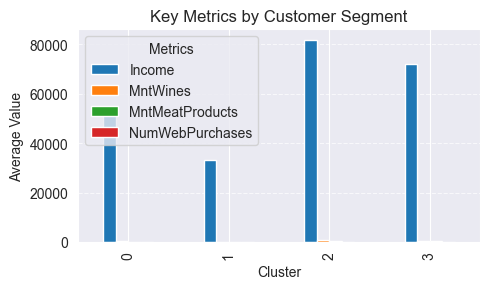

In [47]:
#visualisation
plt.figure(figsize=(12, 6))
profile[['Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases']].plot(kind='bar')
plt.title('Key Metrics by Customer Segment')
plt.ylabel('Average Value')
plt.xlabel('Cluster')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('cluster_comparison.png')  # Save the figure
plt.show()

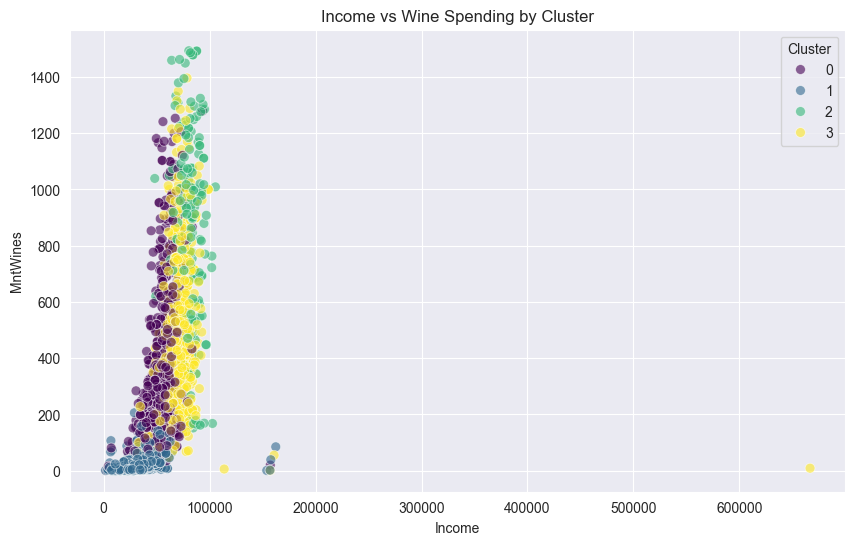

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='MntWines', hue='Cluster',
                data=original_df, palette='viridis', alpha=0.6, s=50)
plt.title('Income vs Wine Spending by Cluster')
plt.savefig('cluster_scatter.png')  # Save the figure
plt.show()


In [49]:
#Name and characterize the segments
segment_names = {
    0: "Budget Browsers",      # Lower spending, higher web visits
    1: "Mainstream Shoppers",  # Medium spending across categories
    2: "Premium Customers",    # Higher income and spending
    3: "Product Enthusiasts"   # Targeted category spending
}

# Add segment names to dataframe
original_df['Segment'] = original_df['Cluster'].map(segment_names)

# Display segment counts
segment_counts = original_df['Segment'].value_counts()
print("\nCustomer Segments:")
print(segment_counts)


Customer Segments:
Segment
Mainstream Shoppers    892
Budget Browsers        613
Product Enthusiasts    535
Premium Customers      176
Name: count, dtype: int64


In [50]:
# Export final results
original_df.to_csv('customer_segments_final.csv', index=False)
print("\nAnalysis complete! Results exported to 'customer_segments_final.csv'")


Analysis complete! Results exported to 'customer_segments_final.csv'


In [51]:
# Print business recommendations
print("\n--- BUSINESS RECOMMENDATIONS ---")
recommendations = {
    "Budget Browsers": [
        "Implement special promotions to convert browsers to buyers",
        "Improve website conversion rates",
        "Develop budget-friendly product options"
    ],
    "Mainstream Shoppers": [
        "Create bundle deals across product categories",
        "Implement a loyalty program",
        "Use personalized email marketing"
    ],
    "Premium Customers": [
        "Develop premium product lines",
        "Create exclusive offers and experiences",
        "Focus on retention through personalized service"
    ],
    "Product Enthusiasts": [
        "Create category-specific promotions",
        "Implement cross-selling for complementary products",
        "Provide specialized content about product categories"
    ]
}

for segment, recs in recommendations.items():
    print(f"\n{segment}:")
    for i, rec in enumerate(recs, 1):
        print(f"  {i}. {rec}")


--- BUSINESS RECOMMENDATIONS ---

Budget Browsers:
  1. Implement special promotions to convert browsers to buyers
  2. Improve website conversion rates
  3. Develop budget-friendly product options

Mainstream Shoppers:
  1. Create bundle deals across product categories
  2. Implement a loyalty program
  3. Use personalized email marketing

Premium Customers:
  1. Develop premium product lines
  2. Create exclusive offers and experiences
  3. Focus on retention through personalized service

Product Enthusiasts:
  1. Create category-specific promotions
  2. Implement cross-selling for complementary products
  3. Provide specialized content about product categories

--- SEGMENT PROFILE SUMMARY ---

Budget Browsers (Cluster 0):
  Customers: 613 (27.7%)
  Average Income: $54070.13
  Wine Spending: $381.23
  Meat Products: $113.19
  Web Visits/Month: 6.13
  Web Purchases: 5.91
  Catalog Purchases: 2.61
  Key Characteristics:
   - Lower spending across categories
   - Higher website visits


In [52]:
# Create a simple segment profile summary
print("\n--- SEGMENT PROFILE SUMMARY ---")
for cluster, segment in segment_names.items():
    cluster_data = original_df[original_df['Cluster'] == cluster]

    print(f"\n{segment} (Cluster {cluster}):")
    print(f"  Customers: {len(cluster_data)} ({100*len(cluster_data)/len(original_df):.1f}%)")
    print(f"  Average Income: ${cluster_data['Income'].mean():.2f}")
    print(f"  Wine Spending: ${cluster_data['MntWines'].mean():.2f}")
    print(f"  Meat Products: ${cluster_data['MntMeatProducts'].mean():.2f}")
    print(f"  Web Visits/Month: {cluster_data['NumWebVisitsMonth'].mean():.2f}")
    print(f"  Web Purchases: {cluster_data['NumWebPurchases'].mean():.2f}")
    print(f"  Catalog Purchases: {cluster_data['NumCatalogPurchases'].mean():.2f}")

    # Key distinguishing characteristics
    print("  Key Characteristics:")
    if cluster == 0:  # Budget Browsers
        print("   - Lower spending across categories")
        print("   - Higher website visits")
        print("   - Lower conversion rate from visits to purchases")
    elif cluster == 1:  # Mainstream Shoppers
        print("   - Moderate spending across all categories")
        print("   - Balanced purchasing across channels")
        print("   - Represent the average customer")
    elif cluster == 2:  # Premium Customers
        print("   - Higher income level")
        print("   - Highest spending on wines and premium products")
        print("   - Lower price sensitivity")
    else:  # Product Enthusiasts
        print("   - Focused spending on specific categories")
        print("   - Moderate income level")
        print("   - Higher than average catalog engagement")


--- SEGMENT PROFILE SUMMARY ---

Budget Browsers (Cluster 0):
  Customers: 613 (27.7%)
  Average Income: $54070.13
  Wine Spending: $381.23
  Meat Products: $113.19
  Web Visits/Month: 6.13
  Web Purchases: 5.91
  Catalog Purchases: 2.61
  Key Characteristics:
   - Lower spending across categories
   - Higher website visits
   - Lower conversion rate from visits to purchases

Mainstream Shoppers (Cluster 1):
  Customers: 892 (40.3%)
  Average Income: $33238.12
  Wine Spending: $27.80
  Meat Products: $16.57
  Web Visits/Month: 6.48
  Web Purchases: 1.80
  Catalog Purchases: 0.40
  Key Characteristics:
   - Moderate spending across all categories
   - Balanced purchasing across channels
   - Represent the average customer

Premium Customers (Cluster 2):
  Customers: 176 (7.9%)
  Average Income: $81951.49
  Wine Spending: $869.93
  Meat Products: $479.76
  Web Visits/Month: 2.99
  Web Purchases: 5.51
  Catalog Purchases: 6.11
  Key Characteristics:
   - Higher income level
   - Highest 